In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from sklearn.linear_model import LinearRegression

# black_scholes or black_scholes_merton
from py_vollib.black_scholes_merton  import black_scholes_merton as bs
from py_vollib.black_scholes_merton.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes_merton.greeks.analytical import delta, gamma, rho, theta, vega
%matplotlib inline

def get_data(tickers, start=None, end=None, interval='1d',OHLC='Adj Close', period='max', dropna=True):
    df = pd.DataFrame()
    for t in tqdm(tickers):
        if period == 'max':
            df[t] = yf.download(t, interval=interval, period=period, progress=False)[OHLC]
        else:
            df[t] = yf.download(t, start, end, interval=interval, progress=False)[OHLC]
    df.dropna(inplace=dropna)
    
    return df

def get_option_chain(ticker, exp_dates): # input yf ticker object
    Agg_options = {}
    # calculate days until option expirations
    days_to_exp = (pd.to_datetime(exp_dates) - dt.datetime.now()).days
    date_days = dict(zip(exp_dates, days_to_exp))

    for date in tqdm(exp_dates):
        Call_chain = ticker.option_chain(date=date)[0]
        Put_chain = ticker.option_chain(date=date)[1]
        
        Call_chain['exp_date'] = date
        Call_chain['days_to_exp'] = date_days[date]
        Put_chain['exp_date'] = date
        Put_chain['days_to_exp'] = date_days[date]
        
        Call_chain['type'] = 'c'
        Put_chain['type'] = 'p'
        
        option_chain = pd.concat([Call_chain, Put_chain], axis=0)

        Agg_options[date] = option_chain
        
    return Agg_options

### Download an option contract, get historical market option prices to derive historical IV and option greeks

In [2]:
### Download option price chain
# specify underlying stock
tkr = "SPY"
ticker = yf.Ticker(tkr)
# get list of expiration dates
exp_dates = ticker.options
# get option chain data
Agg_options = get_option_chain(ticker, exp_dates)
print(f'{len(Agg_options)} Option Chains downloaded, with expirations on: \n{list(Agg_options.keys())}')


### Download spot asset/rate
# get spot asset and risk-free rate data (10Y US treasury yield)
spot_df = yf.download([tkr, '^TNX'], interval='1d', period='max', progress=False)[['Adj Close']].set_axis(['spot','Rf'], axis=1)
# continuously compounded risk-free rate (log_returns)
spot_df['Rf'] = np.log(1 + spot_df.Rf/100)
# 30d forward historical volatility of spot returns
spot_df['HV_30d'] = (
                     spot_df.spot.pct_change(1).dropna()
                     .iloc[::-1].rolling(window=30).std().iloc[::-1]
                     ) * np.sqrt(252) * 100
# current spot price
S0 = spot_df.spot[-1]
# current RF
RF = spot_df.Rf[-1]

print(f'Current Stock Price of {tkr} is: {S0}')

  0%|          | 0/31 [00:00<?, ?it/s]

31 Option Chains downloaded, with expirations on: 
['2023-11-29', '2023-11-30', '2023-12-01', '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08', '2023-12-15', '2023-12-22', '2023-12-29', '2024-01-05', '2024-01-19', '2024-01-31', '2024-02-16', '2024-02-29', '2024-03-15', '2024-03-28', '2024-04-19', '2024-04-30', '2024-05-31', '2024-06-21', '2024-06-28', '2024-09-20', '2024-09-30', '2024-12-20', '2025-01-17', '2025-03-21', '2025-06-20', '2025-12-19', '2026-01-16']
Current Stock Price of SPY is: 454.92999267578125


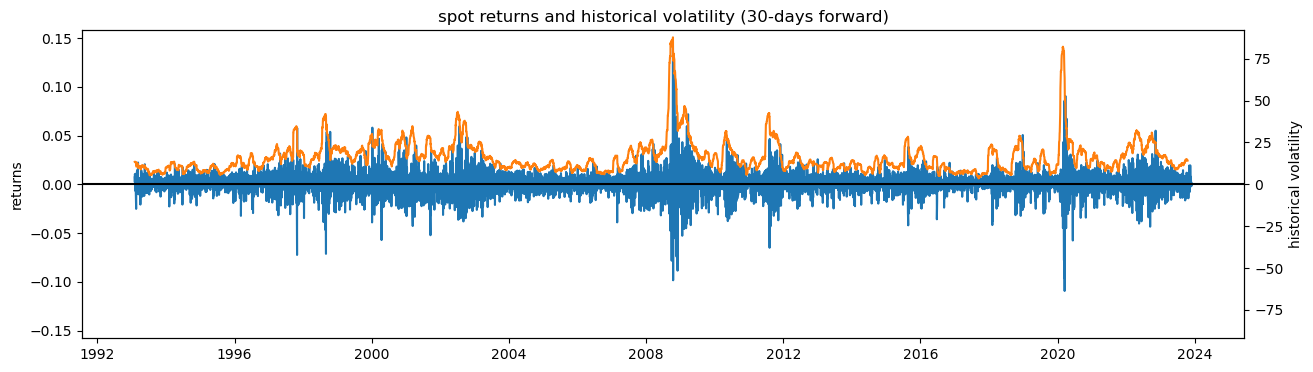

In [3]:
### Spot asset
fig,ax = plt.subplots(figsize=(15,4))
ax1 = ax.twinx()
ax.plot(spot_df.spot.pct_change(1), label='historical returns')
ax1.plot(spot_df.HV_30d, c='tab:orange', label='historical volatility')
ax.axhline(0, c='black');

ax.set_ylabel('returns')
ax1.set_ylabel('historical volatility');
ax.set_title('spot returns and historical volatility (30-days forward)')
ax.set_ylim([-ax.get_ybound()[1],ax.get_ybound()[1]]);
ax1.set_ylim([-ax1.get_ybound()[1],ax1.get_ybound()[1]]);

In [4]:
def get_option_prices(option_contract):
    # download specified option contract and historical prices
    option_prices = yf.download(option_contract.contractSymbol, period='max', progress=False)[['Adj Close']].set_axis(['mkt_price'], axis=1)
    # combine with spot asset data
    spot_df = yf.download([tkr, '^TNX'], interval='1d', period='max', progress=False)[['Adj Close']].set_axis(['spot','Rf'], axis=1)
    option_prices = option_prices.join(spot_df)
    option_prices['DTE'] = (pd.to_datetime(date) - option_prices.index).days
    print(f'Contract: {option_contract.contractSymbol}, ITM: {option_contract.inTheMoney}') 
    return option_prices

def select_option(tkr, date, strike, op_type='c'):
    # download option chain
    ticker = yf.Ticker(tkr)
    exp_dates = ticker.options
    Agg_options = get_option_chain(ticker, exp_dates)
    option_contract = Agg_options[date].query(f"(type == '{op_type}') & strike == {strike}").squeeze(axis=0)
    print(f'selected: Type={op_type}, K={strike}, Expiration={exp_dates[10]}')
    return option_contract

# specify an option contract: exp_date, option type, strike price
tkr='SPY'
date = exp_dates[10]
op_type = 'c'
strike = 450
# download option contract and historical price data
option_contract = select_option(tkr, date, strike, op_type)
option_prices = get_option_prices(option_contract)

# use adj. close as mkt price as historical B-A is not available
# option market price data
c_price = option_contract.loc['lastPrice']
bid = option_contract.bid
ask = option_contract.ask

if (bid == 0) & (ask == 0):
    mkt_price = c_price
    print(f'B-A not available, use last close price as market price: {mkt_price}')
    ba_spread = np.nan
    mid_price = np.nan
else:
    ba_spread = round(100 * (ask - bid) / ask, 2)
    mid_price = (bid + ask) / 2
    mkt_price = mid_price
    print(f'B-A spread: {ba_spread}%, mid price as market price: {mid_price}')
    
# BSM valuation inputs
flag = op_type
S0
K = option_contract.strike
r = RF
T = option_contract.days_to_exp / 252
DY = 0.0144 # S&P500 Dividend Yield
q = np.log(1+DY) # convert to continuous dividend yield
mkt_price

# Market implied volatility (IV)
mkt_iv = option_contract.impliedVolatility
# BS price derived from market IV
bs_price = bs(flag, S0, K, T, r, mkt_iv, q)
# IV from last closing price
mkt_iv_cprice = iv(c_price, S0, K, T, r, q,flag)


if flag == 'c':
    intrinsic_value = max(S0 - K, 0)
    time_value = mkt_price - intrinsic_value
else:
    intrinsic_value = max(K - S0, 0)
    time_value = mkt_price - intrinsic_value
    
print(f'''
DTE: {option_contract.days_to_exp} days remaining

--valuation inputs--
S0: {S0}
K: {K}
r: {r}
T: {T}
q: {q}
mkt_iv: {round(mkt_iv*100,4)}% quoted or {round(mkt_iv_cprice*100,4)}% from closing price

--market prices--
* bid-ask data may show up as 0 when the market is closed, hence making quoted IV very low as well
closing_price: {c_price}
bid: {bid}
ask: {ask}
ba_spread: {round(ba_spread,2)}%
mid_price: {mid_price} (mkt price)
bs_price: {round(bs_price,2)} (theoretical price using mkt iv)

--intrinsic and extrinsic values--
In The Money: {option_contract.inTheMoney}
Intrinsic Value: {intrinsic_value}, ({round(100*intrinsic_value/mkt_price,2)}%)
Time Value: {time_value}, ({round(100*time_value/mkt_price,2)}%)
          ''')

  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=c, K=450, Expiration=2023-12-29
Contract: SPY231229C00450000, ITM: True
B-A not available, use last close price as market price: 9.04

DTE: 29 days remaining

--valuation inputs--
S0: 454.92999267578125
K: 450.0
r: 0.04244627433370006
T: 0.11507936507936507
q: 0.014297304700824394
mkt_iv: 0.001% quoted or 8.599% from closing price

--market prices--
* bid-ask data may show up as 0 when the market is closed, hence making quoted IV very low as well
closing_price: 9.04
bid: 0.0
ask: 0.0
ba_spread: nan%
mid_price: nan (mkt price)
bs_price: 6.37 (theoretical price using mkt iv)

--intrinsic and extrinsic values--
In The Money: True
Intrinsic Value: 4.92999267578125, (54.54%)
Time Value: 4.110007324218749, (45.46%)
          


## Time series analysis of option values

### Option price and returns relative to moneyness

  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=c, K=425, Expiration=2023-12-29
Contract: SPY231229C00425000, ITM: True


  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=c, K=455, Expiration=2023-12-29
Contract: SPY231229C00455000, ITM: False


  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=c, K=475, Expiration=2023-12-29
Contract: SPY231229C00475000, ITM: False


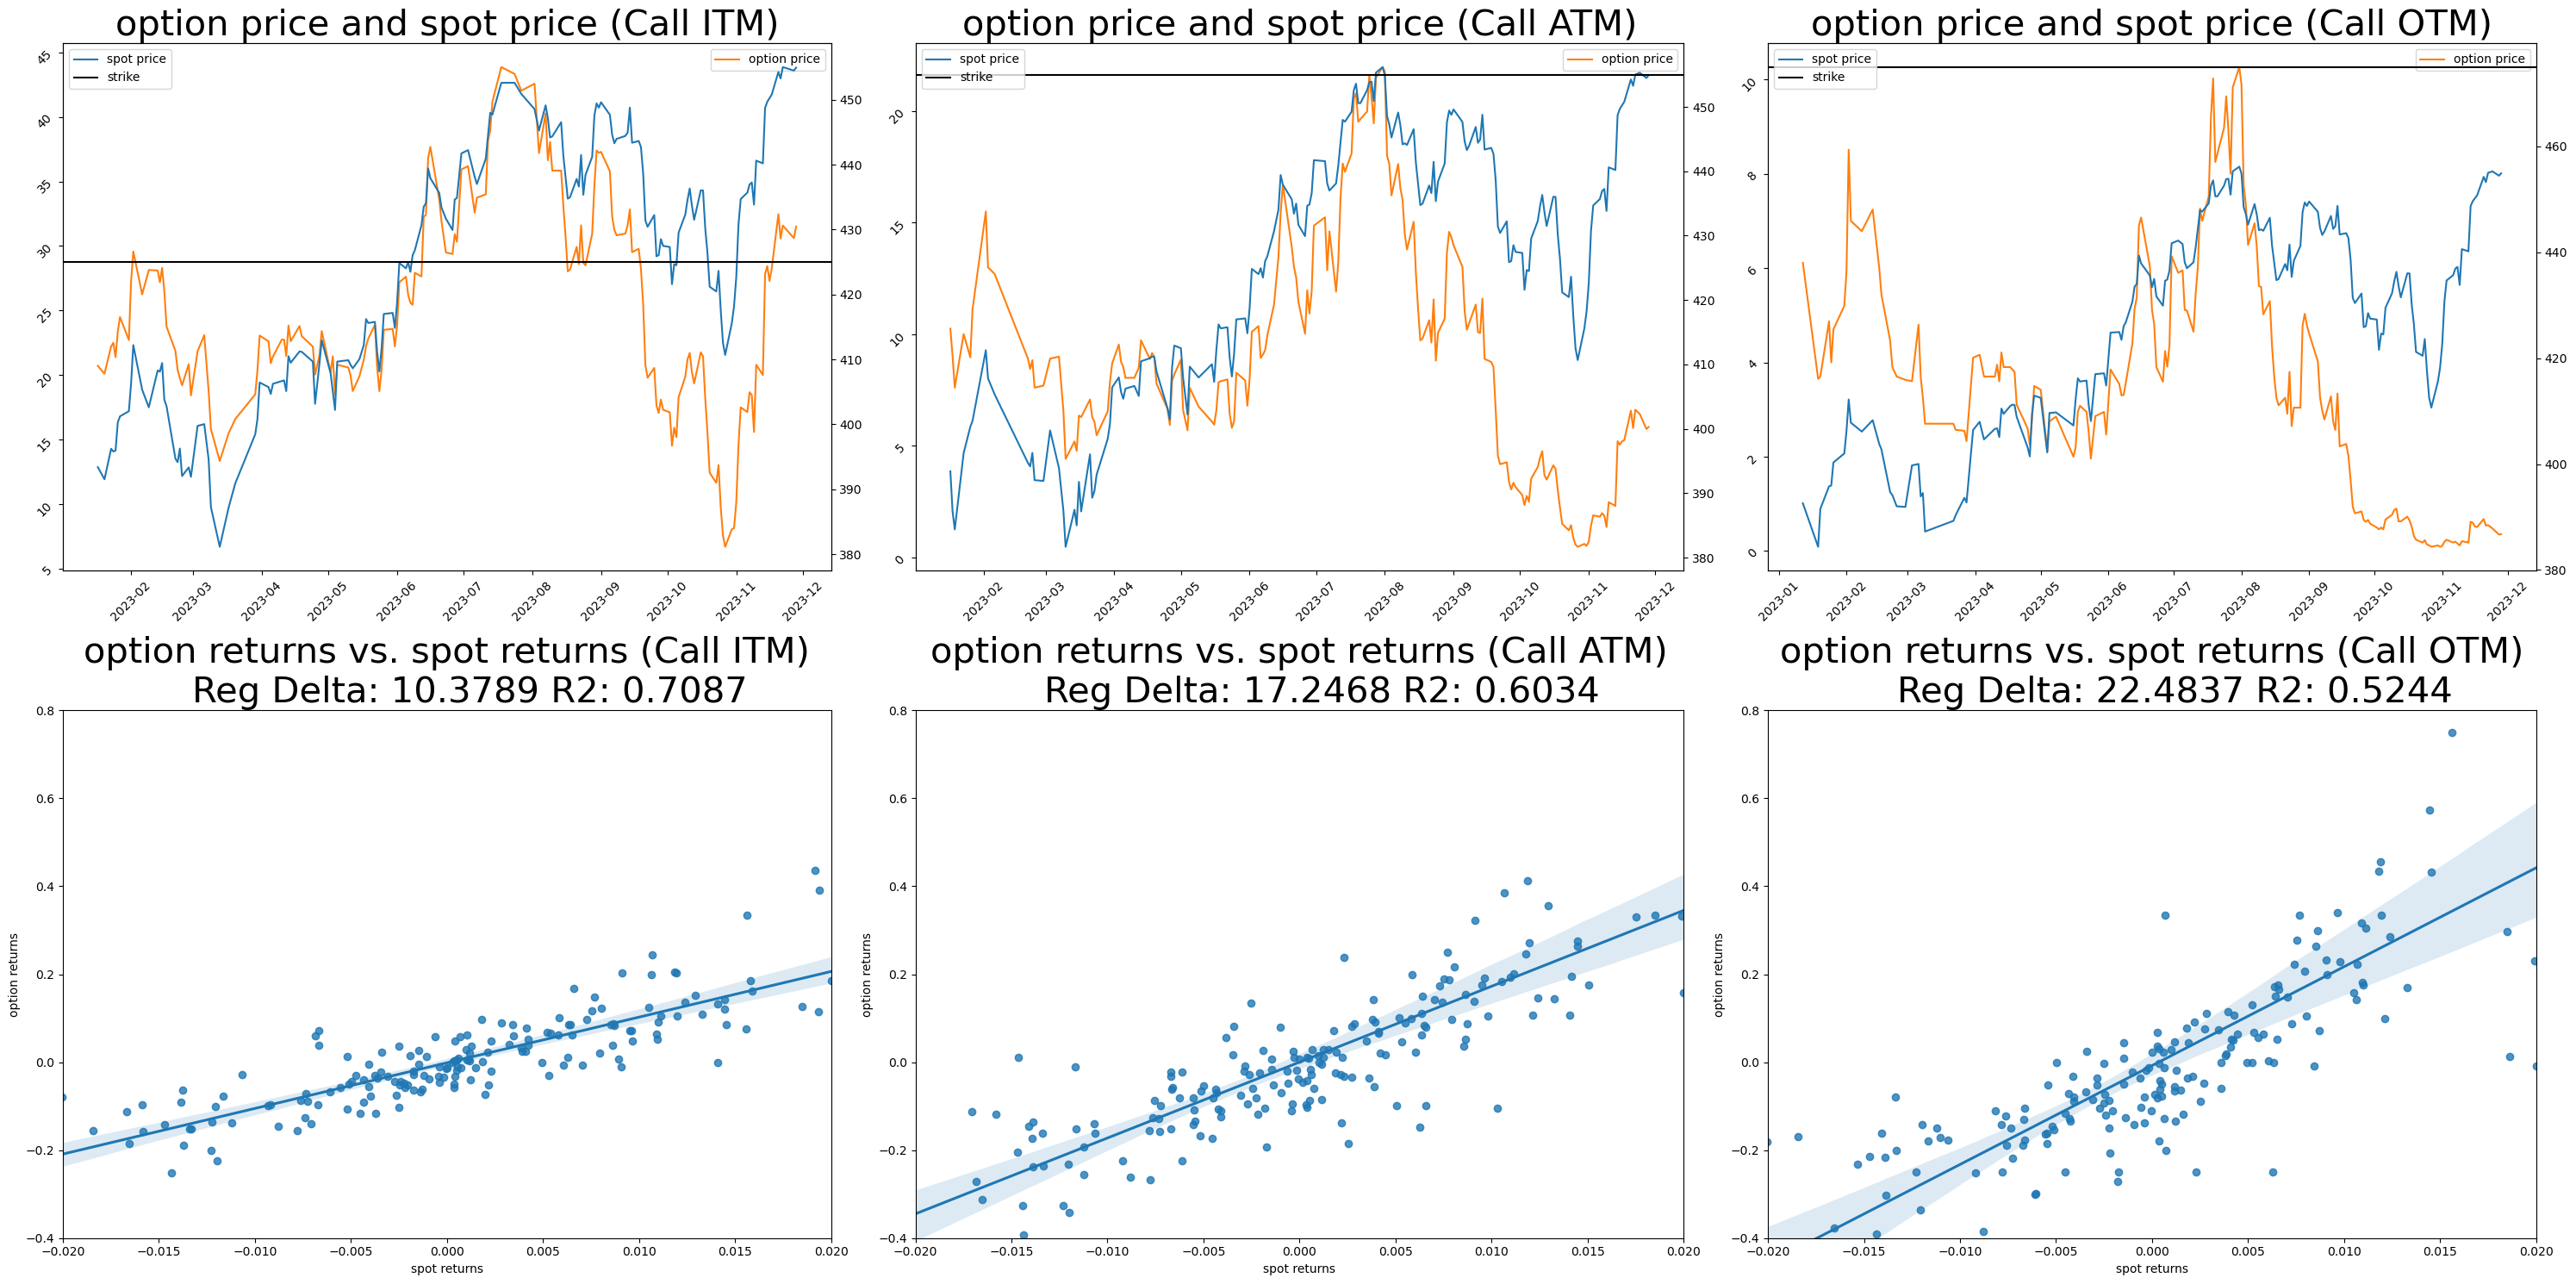

In [5]:
def plot_option_price(ax, df, strike, desc):    
    ax1 = ax.twinx()
    ax.plot(df['mkt_price'], label='option price', c='tab:orange')
    ax1.plot(df['spot'], label='spot price', c='tab:blue');
    ax1.axhline(strike, c='black', label='strike')
    ax.tick_params(rotation=45)
    ax.legend(loc='upper right')
    ax1.legend(loc='upper left')
    ax.set_title(f'option price and spot price ({desc})', size=30)
    return None

def scatter_option_returns(ax, df, desc): 
    X = df[['spot']].pct_change().dropna()
    y = df['mkt_price'].pct_change().dropna()
    sns.regplot(x=X, y=y, ax=ax);
    model = LinearRegression().fit(X,y)
    delta = round(model.coef_[0],4)
    R_sq = round(model.score(X,y),4)
    ax.set_title(f'''option returns vs. spot returns ({desc})
    Reg Delta: {delta} R2: {R_sq}''', size=30)
    ax.set_xlabel('spot returns')
    ax.set_ylabel('option returns');
    ax.set_xlim([-0.02,0.02])
    ax.set_ylim([-0.4,0.8])
    return None

# download option contract historical prices
### holding DTE constant
date = exp_dates[10]
# S0: 454.92999267578125

tkr = 'SPY'
op_type = 'c' 

### ITM Call
strike_in = 425 # ITM
option_contract = select_option(tkr, date, strike_in, op_type)
option_c_ITM = get_option_prices(option_contract)
### ATM Call
strike_at = 455 # ATM
option_contract = select_option(tkr, date, strike_at, op_type)
option_c_ATM = get_option_prices(option_contract)
### OTM Call
strike_out = 475 # OTM
option_contract = select_option(tkr, date, strike_out, op_type)
option_c_OTM = get_option_prices(option_contract)

# option and spot price/returns time series
fig,ax = plt.subplots(2,3, figsize=(30,15))
plot_option_price(ax[0,0], option_c_ITM, strike_in, 'Call ITM')
scatter_option_returns(ax[1,0], option_c_ITM, 'Call ITM')

plot_option_price(ax[0,1], option_c_ATM, strike_at, 'Call ATM')
scatter_option_returns(ax[1,1], option_c_ATM, 'Call ATM')

plot_option_price(ax[0,2], option_c_OTM, strike_out, 'Call OTM')
scatter_option_returns(ax[1,2], option_c_OTM, 'Call OTM')
plt.tight_layout()

  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=p, K=425, Expiration=2023-12-29
Contract: SPY231229P00425000, ITM: False


  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=p, K=455, Expiration=2023-12-29
Contract: SPY231229P00455000, ITM: True


  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=p, K=475, Expiration=2023-12-29
Contract: SPY231229P00475000, ITM: True


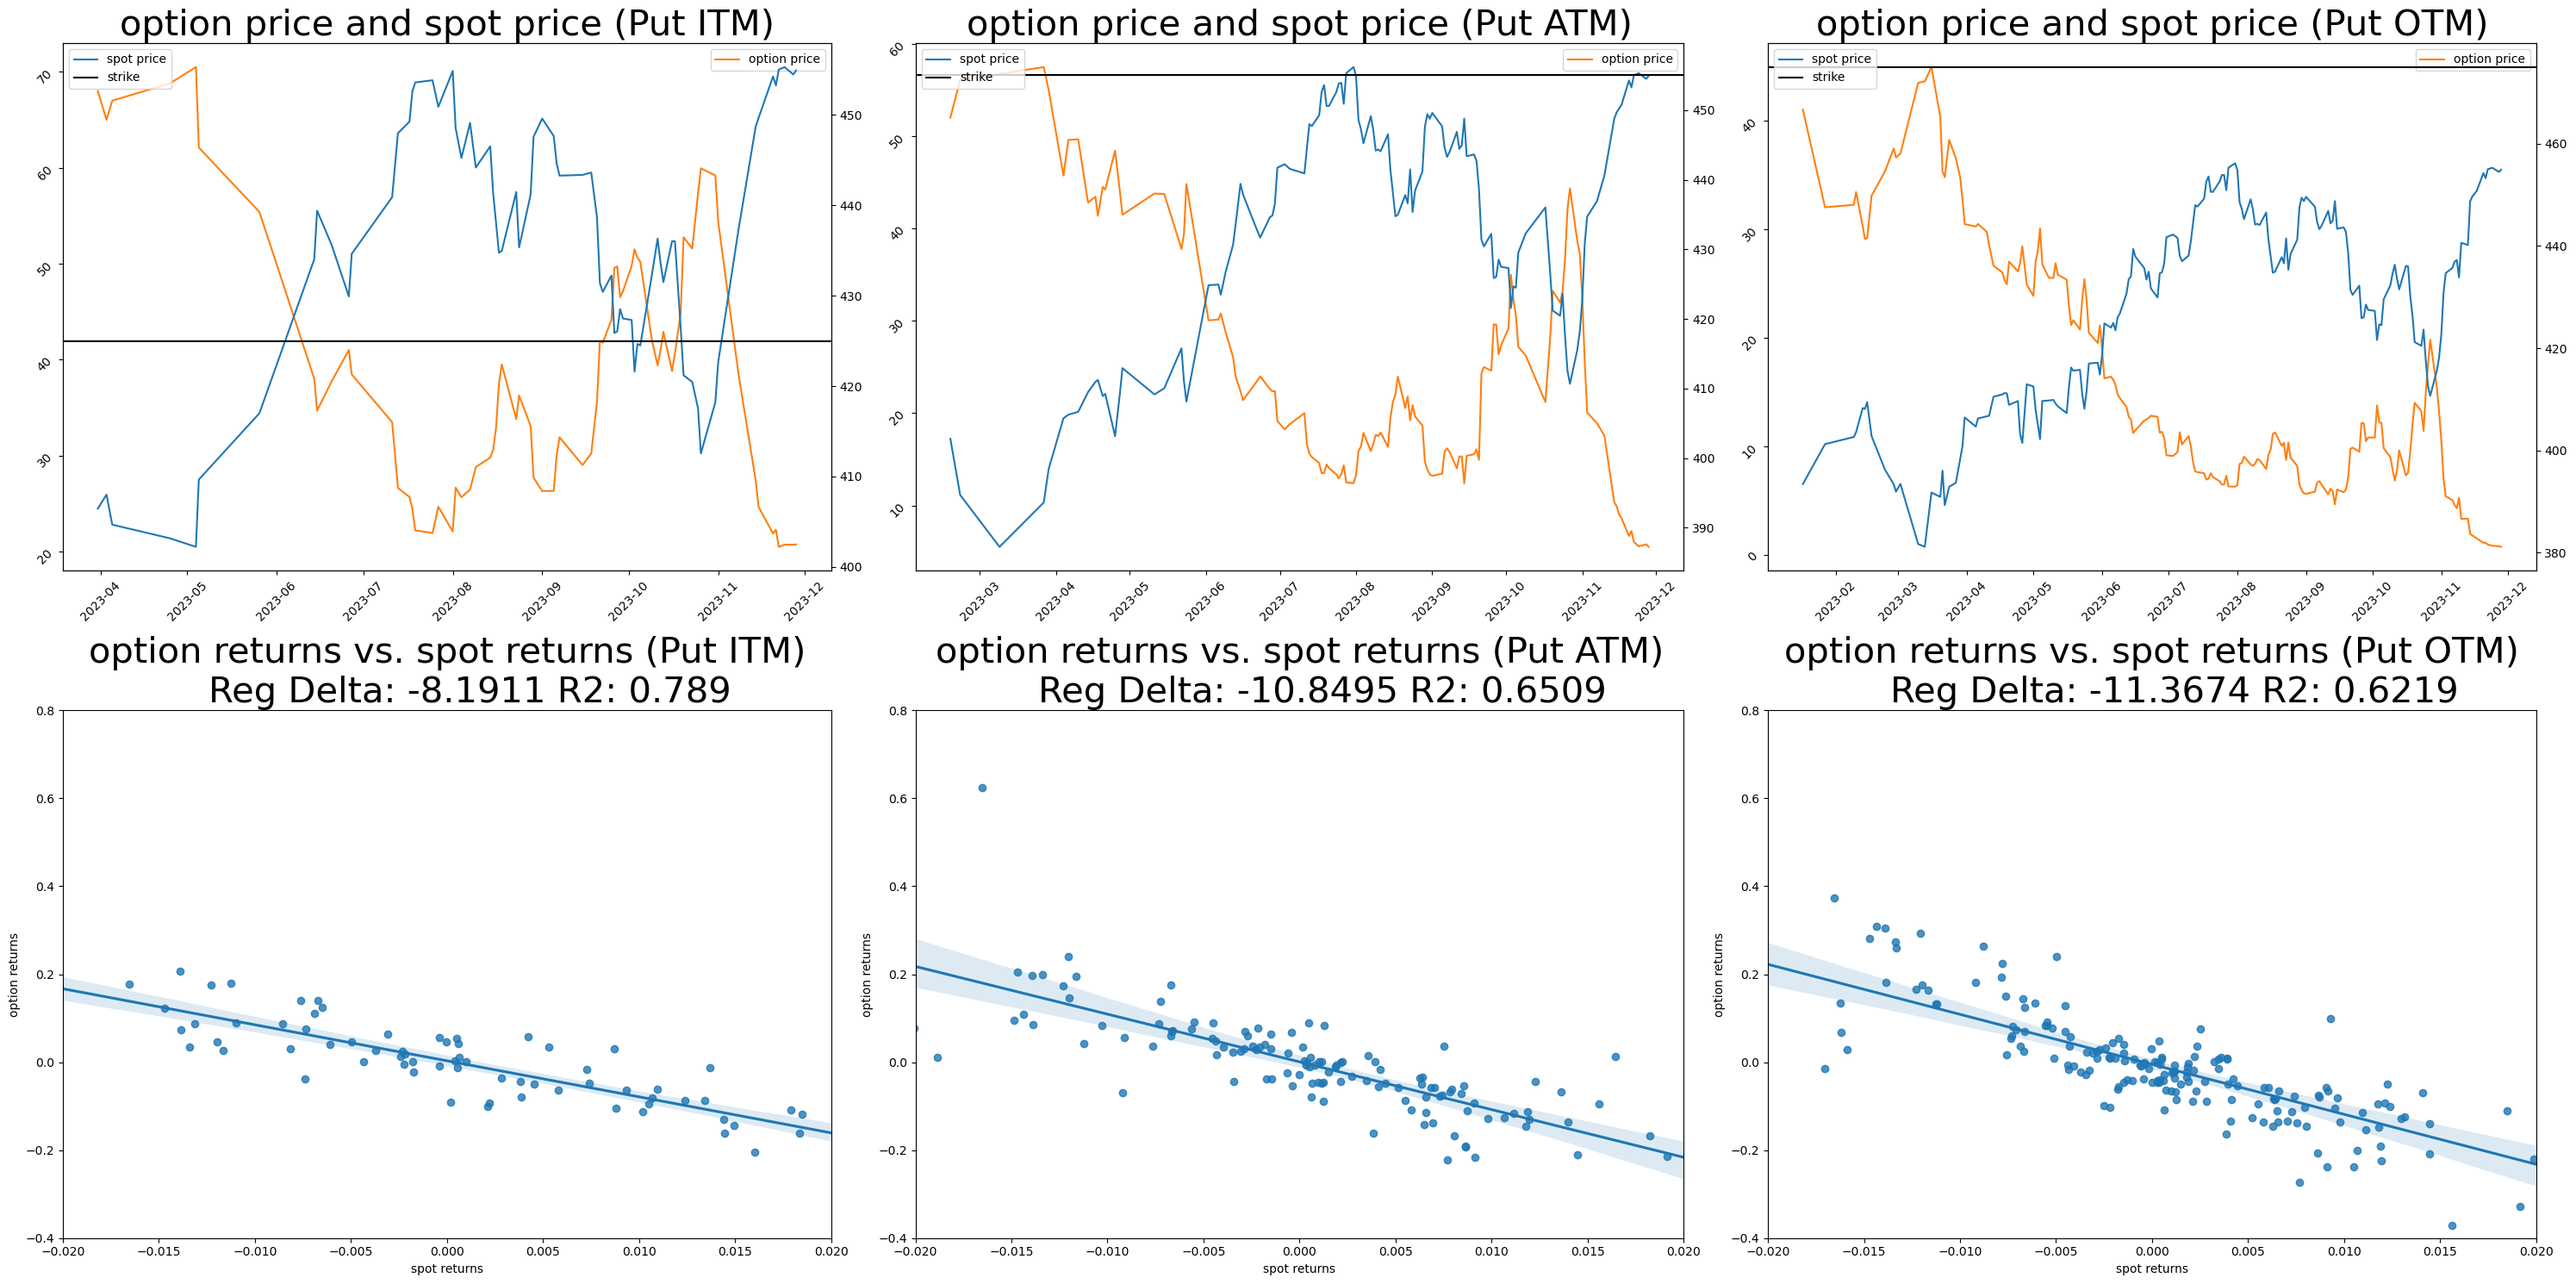

In [6]:
date = exp_dates[10]
tkr = 'SPY'
op_type = 'p' 

### OTM Put
strike_out = 425 # OTM
option_contract = select_option(tkr, date, strike_out, op_type)
option_p_OTM = get_option_prices(option_contract)
### ATM Put
strike_at = 455 # ATM
option_contract = select_option(tkr, date, strike_at, op_type)
option_p_ATM = get_option_prices(option_contract)
### ITM Put
strike_in = 475 # ITM
option_contract = select_option(tkr, date, strike_in, op_type)
option_p_ITM = get_option_prices(option_contract)

# option and spot price/returns time series
fig,ax = plt.subplots(2,3, figsize=(30,15))
plot_option_price(ax[0,0], option_p_ITM, strike_out, 'Put ITM')
scatter_option_returns(ax[1,0], option_p_ITM, 'Put ITM')

plot_option_price(ax[0,1], option_p_ATM, strike_at, 'Put ATM')
scatter_option_returns(ax[1,1], option_p_ATM, 'Put ATM')

plot_option_price(ax[0,2], option_p_OTM, strike_in, 'Put OTM')
scatter_option_returns(ax[1,2], option_p_OTM, 'Put OTM')
plt.tight_layout()

### Option historical IV and Greeks

In [7]:
def IV_and_greeks(df , q, flag):
    # derive historical mkt iv from historical mkt price (treating mkt iv as given)
    df['mkt_iv'] = df[['mkt_price','spot','DTE','Rf']].apply(lambda x : iv(x[0], x[1], strike, x[2]/252, x[3]/100,q, op_type) * 100, axis=1)

    # using the historical mkt iv derived, calculate historical option greeks of the option contract
    df = df.assign(
        delta = df[['spot','DTE','Rf','mkt_iv']].apply(lambda x : delta(flag, x[0], K, x[1]/252, x[2]/100, x[3]/100,q), axis=1),
        gamma = df[['spot','DTE','Rf','mkt_iv']].apply(lambda x : gamma(flag, x[0], K, x[1]/252, x[2]/100, x[3]/100,q), axis=1),
        rho = df[['spot','DTE','Rf','mkt_iv']].apply(lambda x : rho(flag, x[0], K, x[1]/252, x[2]/100, x[3]/100,q), axis=1),
        theta = df[['spot','DTE','Rf','mkt_iv']].apply(lambda x : theta(flag, x[0], K, x[1]/252, x[2]/100, x[3]/100,q), axis=1),
        vega = df[['spot','DTE','Rf','mkt_iv']].apply(lambda x : vega(flag, x[0], K, x[1]/252, x[2]/100, x[3]/100,q), axis=1)
    )
    # get historical instrinsic and time values
    if flag == 'c':
        df['intrinsic_val'] = np.where(df.spot > K, df.spot - K, 0)
        df['time_val'] = df['mkt_price'] - df['intrinsic_val']
    else:
        df['intrinsic_val'] = np.where(K > df.spot, K - df.spot, 0)
        df['time_val'] = df['mkt_price'] - df['intrinsic_val']
    return df

def plot_greeks(df):
    fig,ax = plt.subplots(3,1, figsize=(25,15))
    ax1 = ax[0].twinx()
    axi = ax[0].twinx()
    ax2 = ax[1].twinx()
    axj = ax[1].twinx()
    ax3 = ax[2].twinx()
    axk = ax[2].twinx()
    axi.spines["right"].set_position(("axes", 1.06))
    axj.spines["right"].set_position(("axes", 1.06))
    axk.spines["right"].set_position(("axes", 1.06))

    df['mkt_price'].plot(ax=ax[0], c='tab:orange');
    df['mkt_iv'].plot(ax=axi, c='tab:red');
    df['spot'].plot(ax=ax1, c='tab:blue');
    ax1.axhline(strike, c='black', label='strike')

    df['delta'].plot(ax=ax[1], c='tab:orange');
    df['gamma'].plot(ax=ax2, c='tab:blue');
    df['intrinsic_val'].plot(ax=axj, c='gold');

    df['vega'].plot(ax=ax[2], c='tab:red');
    df['theta'].plot(ax=ax3, c='tab:green');
    df['time_val'].plot(ax=axk, c='magenta');


    ax[0].set_title('Option price and Spot price')
    ax[0].legend(loc='lower center')
    ax1.legend(loc='lower left')
    ax[1].set_title('Delta and Gamma (Intrinsic Leg of Option Value)')
    ax[1].legend(loc='upper left')
    ax2.legend(loc='lower left')
    ax[2].set_title('Vega and Theta (Extrinsic Leg of Option Value)')
    ax[2].legend(loc='upper left')
    ax3.legend(loc='lower left')

    axi.legend(loc='upper center')
    axj.legend(loc='upper center')
    axk.legend(loc='upper center')

    ax[0].set_ylabel("option price")
    ax1.set_ylabel("spot price")
    axi.set_ylabel("Market IV")
    ax[1].set_ylabel("delta")
    ax2.set_ylabel("gamma")
    axj.set_ylabel("Intrinsic Value")
    ax[2].set_ylabel("vega")
    ax3.set_ylabel("theta")
    axk.set_ylabel("Extrinsic Value")
    plt.tight_layout()
    return None

  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=c, K=450, Expiration=2023-12-29
Contract: SPY231229C00450000, ITM: True


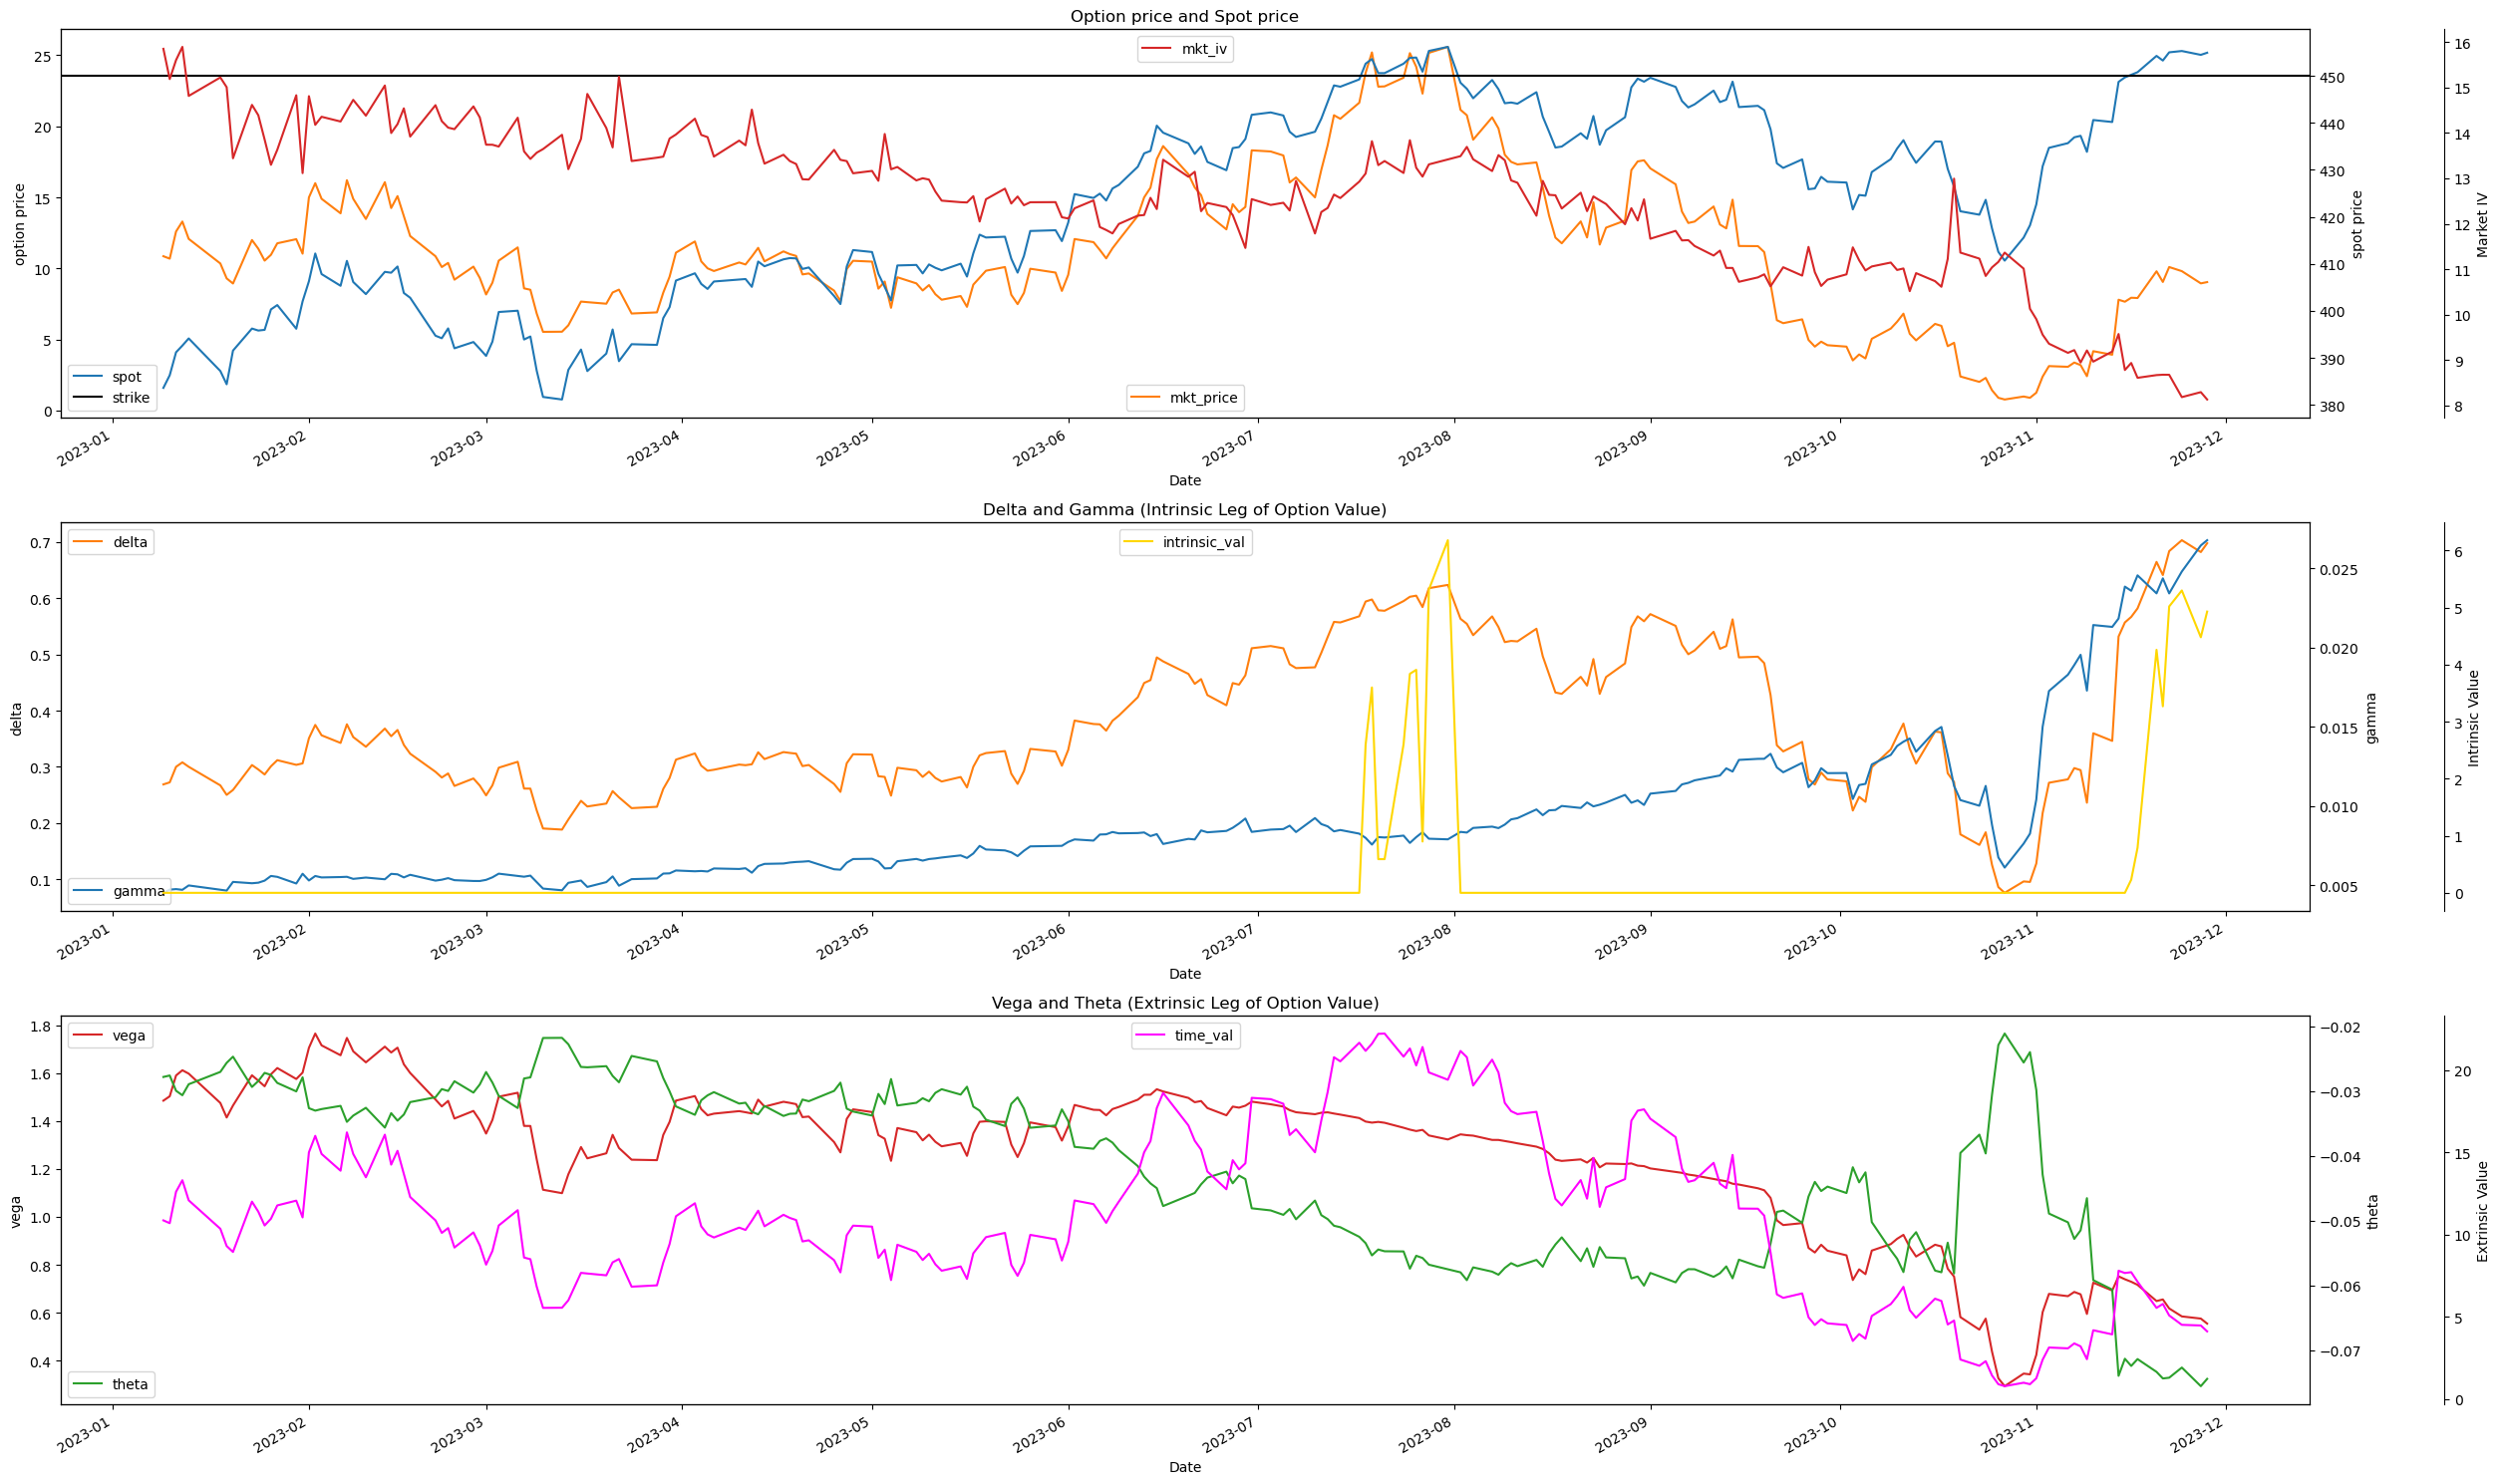

In [8]:
### ATM Call
date = exp_dates[10]
tkr = 'SPY'
op_type = 'c' 
strike = 450
option_contract = select_option(tkr, date, strike, op_type)
option_prices = get_option_prices(option_contract)
# calculate historical IV and greeks
option_prices = IV_and_greeks(option_prices , q, op_type)

### ITM Call
# plot greeks by intrinsic and extrinsic values
plot_greeks(option_prices)

  0%|          | 0/31 [00:00<?, ?it/s]

selected: Type=p, K=450, Expiration=2023-12-29
Contract: SPY231229P00450000, ITM: False


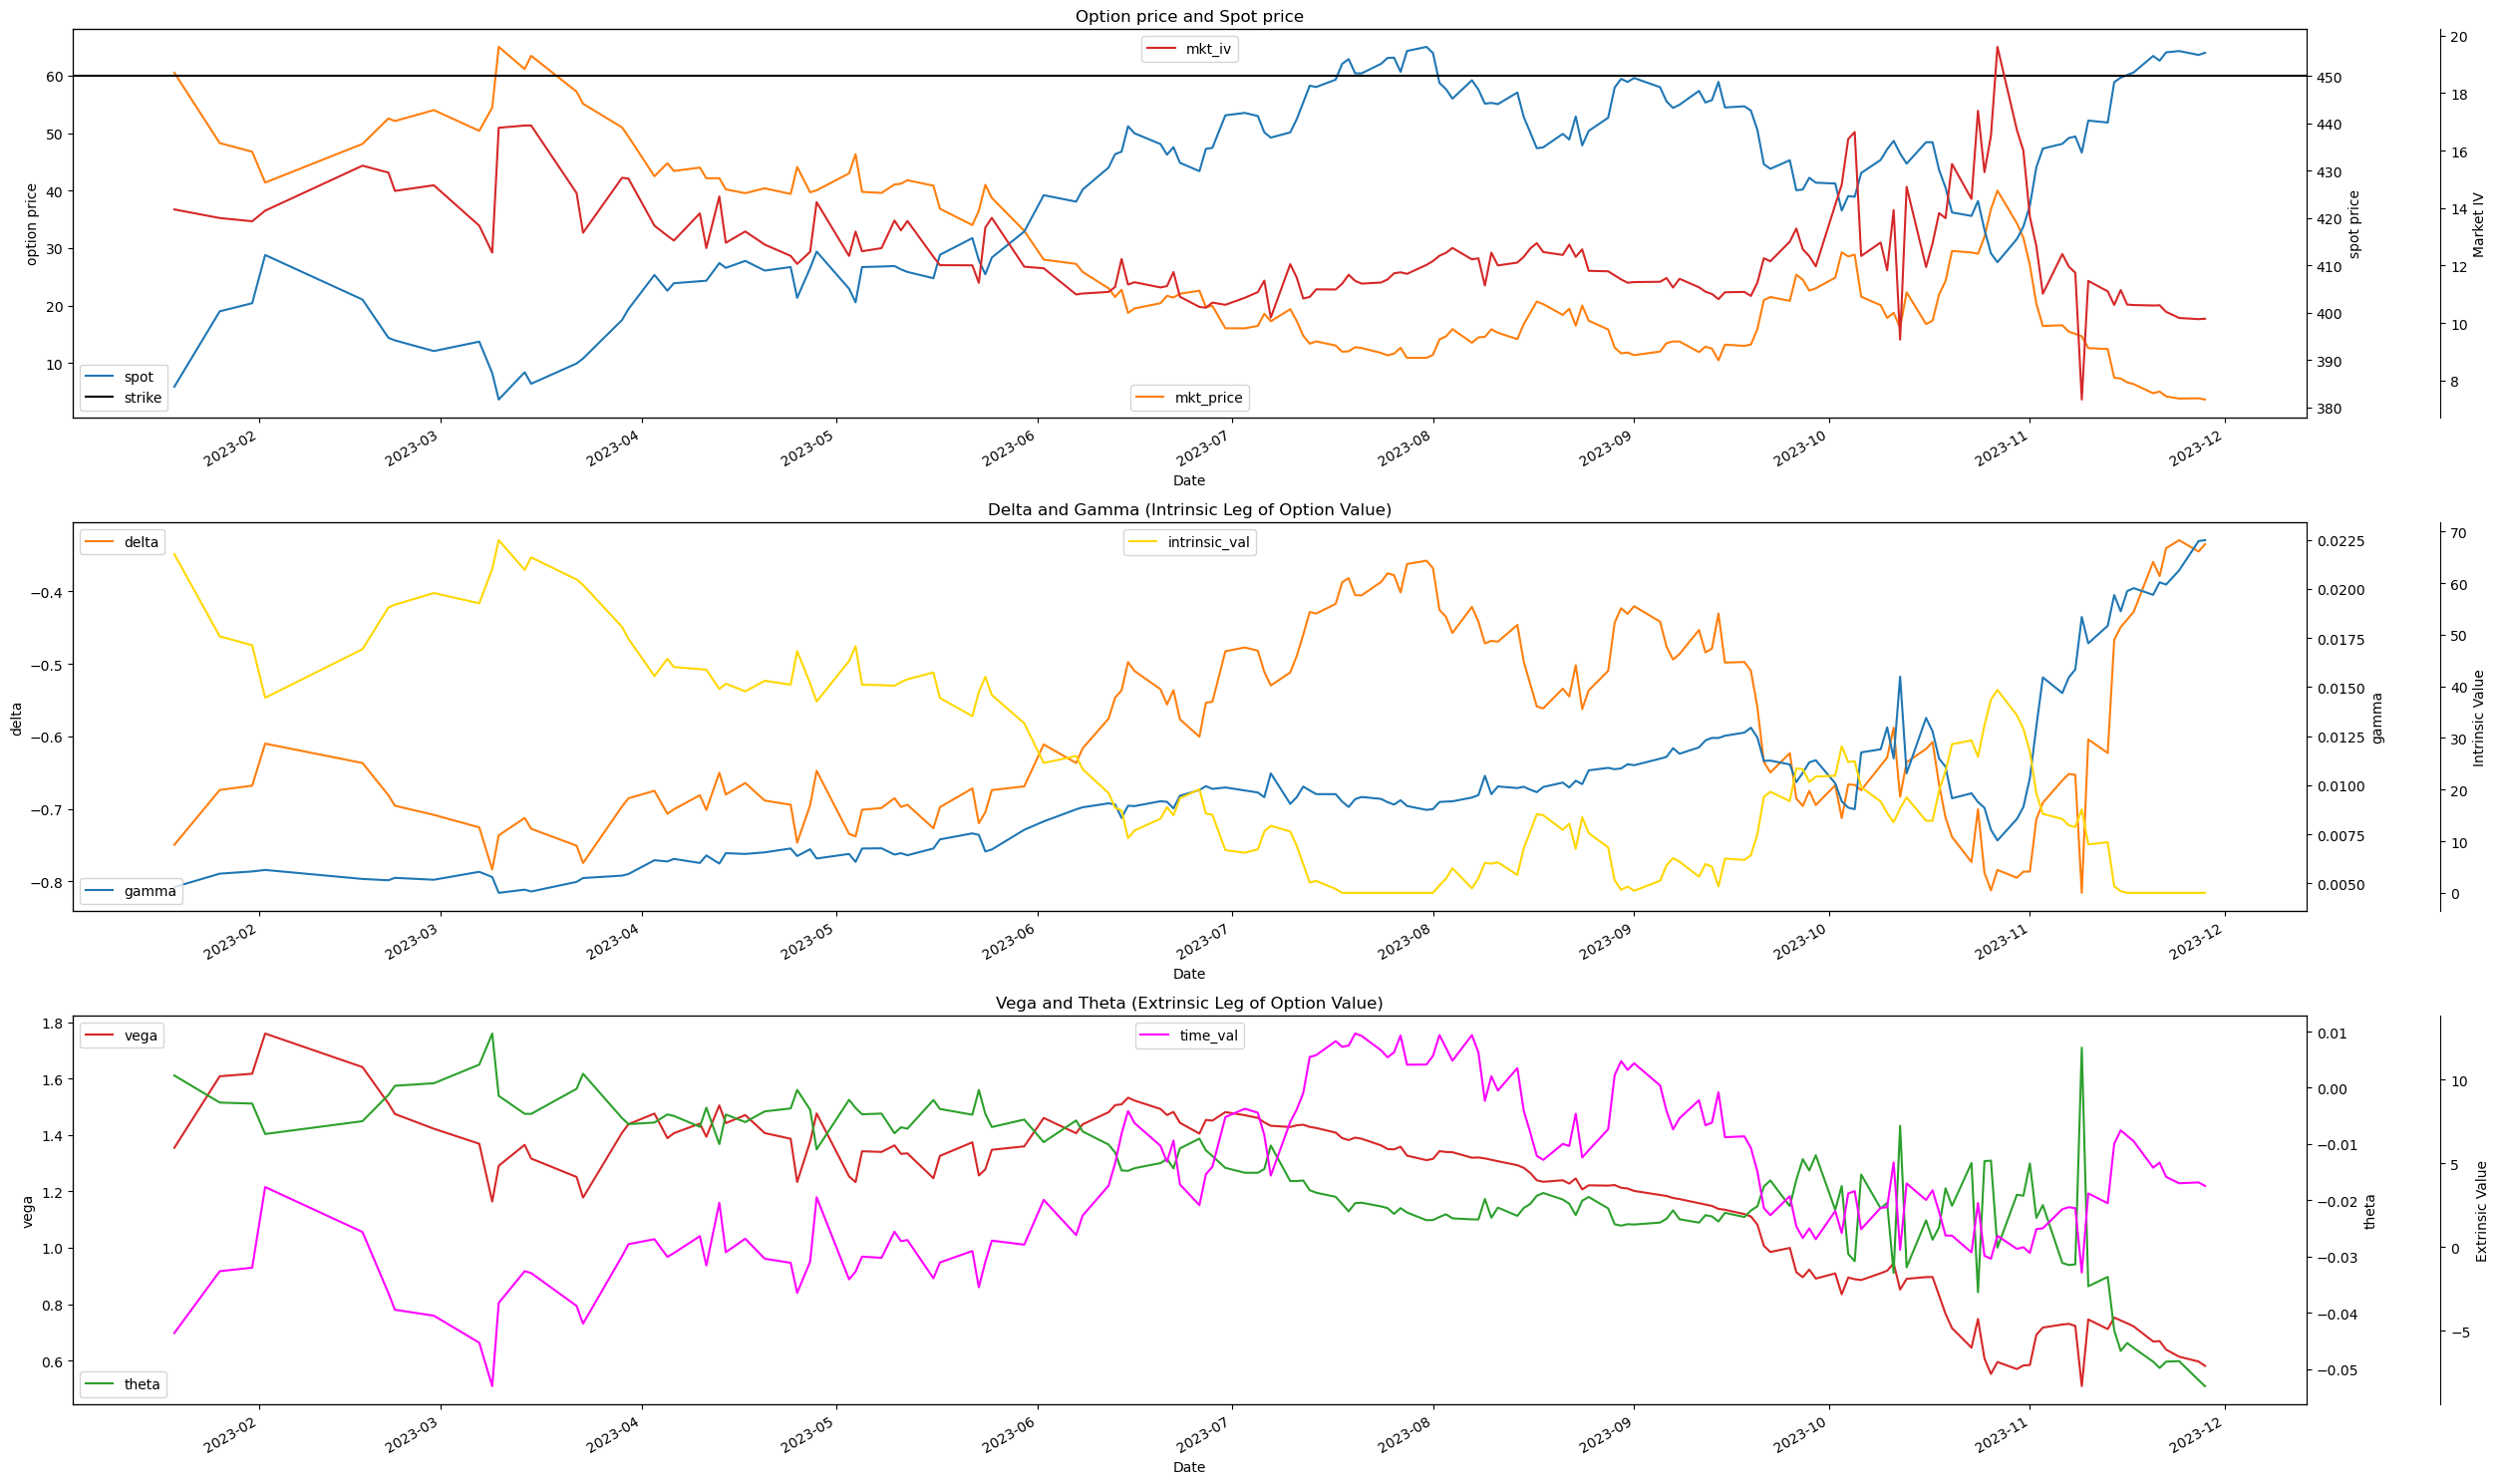

In [9]:
### ATM Put
date = exp_dates[10]
tkr = 'SPY'
op_type = 'p' 
strike = 450
option_contract = select_option(tkr, date, strike, op_type)
option_prices = get_option_prices(option_contract)
# calculate historical IV and greeks
option_prices = IV_and_greeks(option_prices , q, op_type)

### ITM Call
# plot greeks by intrinsic and extrinsic values
plot_greeks(option_prices)

### option payoff and historical option price distribution on payoff

type: p, expiration: 2024-01-19, strike: 450


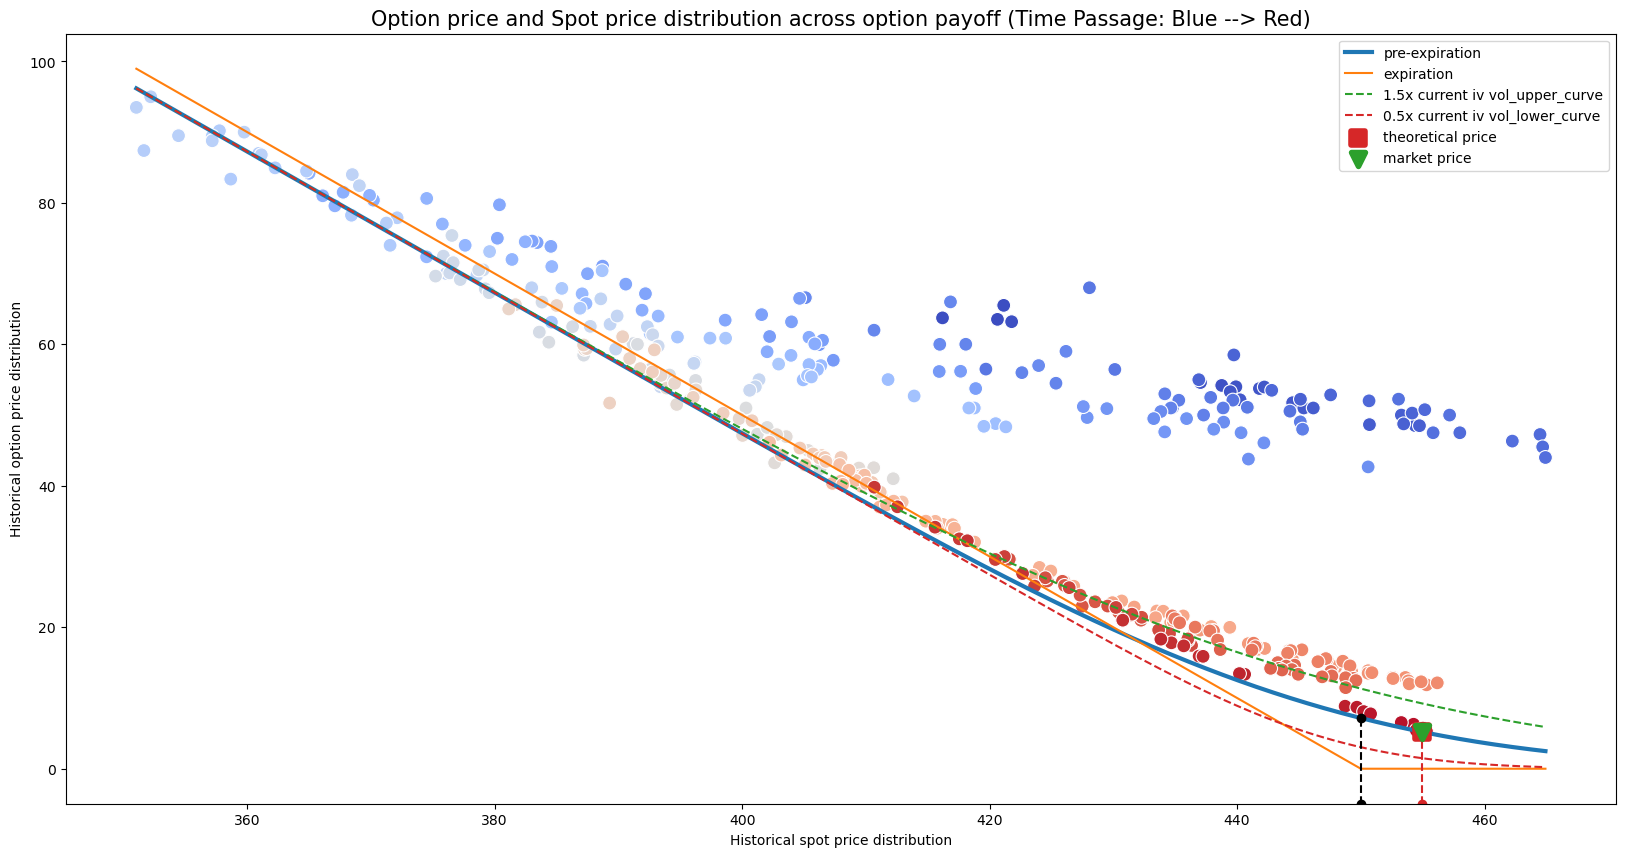

In [10]:
def price_movement_map(option_prices, flag, S0, K, T, r, mkt_iv_cprice, q):
    # generate payoffs
    # range of maturity spot prices
    ST = np.linspace(option_prices.spot.min(), option_prices.spot.max(), num=1000)
    # theoretical curve before expiration at current mkt iv, all else constant
    pre_curve = [bs(flag, S, K, T, r, mkt_iv_cprice, q) for S in ST]
    payoff_df = pd.DataFrame(zip(ST,pre_curve), columns=['ST','pre_curve'])
    # theoretical curve at expiration (inputs other than S and K do not really matter, time value collapse to 0 and 100% consists of intrinsic value)
    payoff_df['exp_curve'] = [bs(flag, S, K, 0, r, mkt_iv_cprice, q) for S in ST]

    vol_up = 0.5
    payoff_df['vol_upper_curve'] = [bs(flag, S, K, T, r, mkt_iv_cprice*(1+vol_up), q) for S in ST] 
    payoff_df['vol_lower_curve'] = [bs(flag, S, K, T, r, mkt_iv_cprice*(1-vol_up), q) for S in ST] 

    fig,ax = plt.subplots(figsize=(20,10))
    plt.plot(payoff_df.ST, payoff_df.pre_curve, label='pre-expiration', linewidth=3);
    plt.plot(payoff_df.ST, payoff_df.exp_curve, label='expiration');
    plt.plot(payoff_df.ST, payoff_df.vol_upper_curve, label=f'{1+vol_up}x current iv vol_upper_curve', linestyle='--');
    plt.plot(payoff_df.ST, payoff_df.vol_lower_curve, label=f'{1-vol_up}x current iv vol_lower_curve', linestyle='--');
    plt.scatter(S0, bs(flag, S0, K, T, r, mkt_iv_cprice, q), c='tab:red', marker='s', label='theoretical price', s=100, linewidth=4, zorder=3)
    plt.scatter(S0, mkt_price, c='tab:green', marker='v', label='market price', s=100, linewidth=4, zorder=3);
    sns.scatterplot(x=option_prices.spot, y=option_prices.mkt_price, hue=option_prices.index, palette='coolwarm', legend=False, s=100)
    plt.legend();

    y_range = ax.get_ybound()[1] - ax.get_ybound()[0]
    plt.axvline(x=K, ymax=(-ax.get_ybound()[0]+bs(flag, K, K, T, r, mkt_iv_cprice, q))/y_range, c='black', linestyle='--', label='strike', marker='o');
    plt.axvline(x=S0, ymax=(-ax.get_ybound()[0]+bs(flag, S0, K, T, r, mkt_iv_cprice, q))/y_range, c='tab:red', linestyle='--', label='spot', marker='o');
    plt.ylabel('Historical option price distribution')
    plt.xlabel('Historical spot price distribution')
    plt.title('Option price and Spot price distribution across option payoff (Time Passage: Blue --> Red)', size=15)
    return None

# specify an option contract: exp_date, option type, strike price
date = exp_dates[12]
op_type = 'p'
strike = 450
option_contract = Agg_options[date].query(f"(type == '{op_type}') & strike == {strike}").squeeze(axis=0)

# download option contract historical prices; use adj. close as mkt price as historical B-A is not available
option_prices = yf.download(option_contract.loc['contractSymbol'], period='max', progress=False)[['Adj Close']].set_axis(['mkt_price'], axis=1)
option_prices = option_prices.join(spot_df)
option_prices['DTE'] = (pd.to_datetime(date) - option_prices.index).days
print(f'type: {op_type}, expiration: {date}, strike: {strike}')

# option market price data
c_price = option_contract.loc['lastPrice'] 

# valuation inputs
flag = op_type
S0 = spot_df.spot[-1]
K = option_contract.loc['strike']
r = spot_df.Rf[-1]
T = option_contract.loc['days_to_exp'] / 252
DY = 0.0144
q = np.log(1+DY) # continuous dividend yield
# closing price used for market data, b/c B-A data are sometimes not available pre-market
mkt_price = c_price
mkt_iv = option_contract.loc['impliedVolatility']
mkt_iv_cprice = iv(c_price, S0, K, T, r, q,flag)

price_movement_map(option_prices, flag, S0, K, T, r, mkt_iv_cprice, q)

type: c, expiration: 2024-01-19, strike: 450


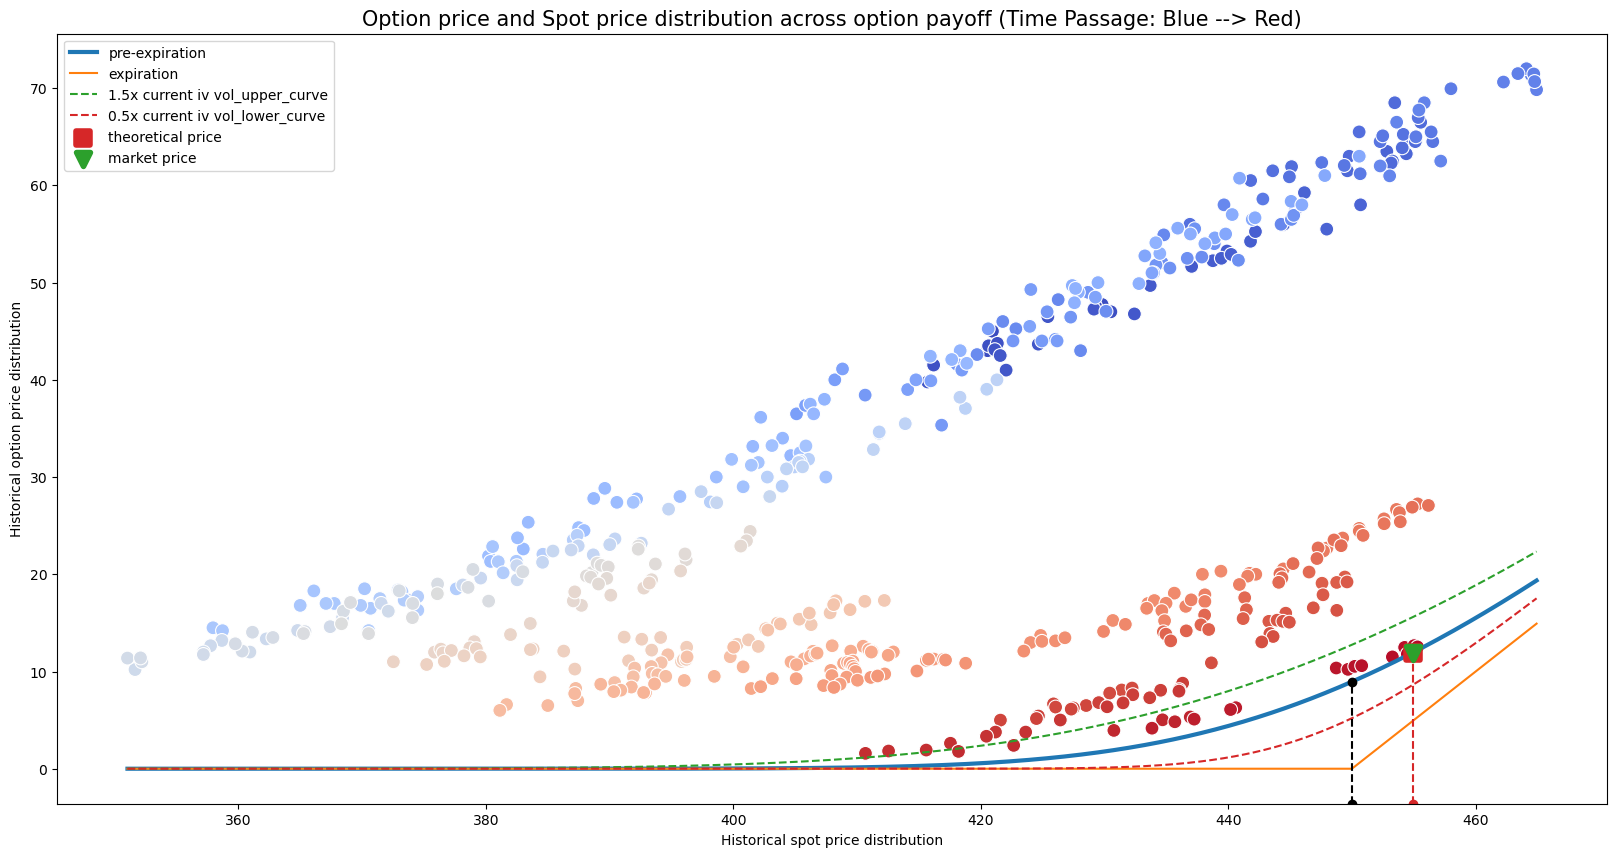

In [11]:
# specify an option contract: exp_date, option type, strike price
date = exp_dates[12]
op_type = 'c'
strike = 450
option_contract = Agg_options[date].query(f"(type == '{op_type}') & strike == {strike}").squeeze(axis=0)

# download option contract historical prices; use adj. close as mkt price as historical B-A is not available
option_prices = yf.download(option_contract.loc['contractSymbol'], period='max', progress=False)[['Adj Close']].set_axis(['mkt_price'], axis=1)
option_prices = option_prices.join(spot_df)
option_prices['DTE'] = (pd.to_datetime(date) - option_prices.index).days
print(f'type: {op_type}, expiration: {date}, strike: {strike}')

# option market price data
c_price = option_contract.loc['lastPrice'] 

# valuation inputs
flag = op_type
S0 = spot_df.spot[-1]
K = option_contract.loc['strike']
r = spot_df.Rf[-1]
T = option_contract.loc['days_to_exp'] / 252
DY = 0.0144
q = np.log(1+DY) # continuous dividend yield
# closing price used for market data, b/c B-A data are sometimes not available pre-market
mkt_price = c_price
mkt_iv = option_contract.loc['impliedVolatility']
mkt_iv_cprice = iv(c_price, S0, K, T, r, q,flag)

price_movement_map(option_prices, flag, S0, K, T, r, mkt_iv_cprice, q)